# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

- Импорт нужных библиотек:

In [699]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as s
pd.set_option('display.max_rows', 100) #None

### Шаг 1. Откройте файл с данными и изучите общую информацию
- Путь к файлу: ../datasets/real_estate_data.csv
- Скачать датасет
- Загрузите данные из файла в датафрейм.
- Изучите общую информацию о полученном датафрейме.
- Постройте общую гистограмму для всех столбцов таблицы. Например, для датафрейма data это можно сделать командой data.hist(figsize=(15, 20)).


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.7,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.0,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.5,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.00000000000001
23696,18,2500000.0,56.7,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.0,17.0,NaN,12,NaN,...,23.3,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23698,4,1350000.0,32.3,2017-07-21T00:00:00,1,2.5,5.0,12.3,1,NaN,...,9.0,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


total_images - 0%
last_price - 0%
total_area - 0%
first_day_exposition - 0%
rooms - 0%
ceiling_height - 39%
floors_total - 0%
living_area - 8%
floor - 0%
is_apartment - 88%
studio - 0%
open_plan - 0%
kitchen_area - 10%
balcony - 49%
locality_name - 0%
airports_nearest - 23%
cityCenters_nearest - 23%
parks_around3000 - 23%
parks_nearest - 66%
ponds_around3000 - 23%
ponds_nearest - 62%
days_exposition - 13%


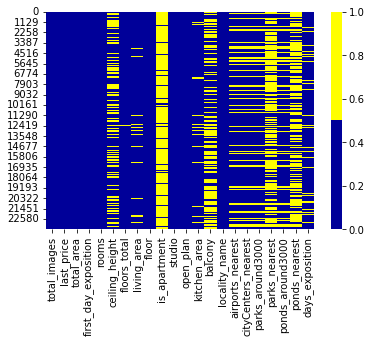

In [701]:
data = pd.read_csv('../datasets/real_estate_data.csv',  sep='\t', decimal = ',')

#отобразим первые 5 строк:
display(data.tail())

#глянем общую информацию
#data.info()

#data.hist(figsize=(15, 20))

#Построим тепловую карту пропущенных значений
cols = data.columns
colours = ['#000099', '#ffff00'] 
s.heatmap(data[cols].isnull(), cmap=s.color_palette(colours))

#Процентный список пропущенных данных
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

   


In [702]:
#Глянем что у нас в каждом  столбце за данные
for a in data.columns:
    print(a)
    exec( 'print(data['+ '\'' + a + '\'' + '].value_counts())') 
    print('')

total_images
10    1798
9     1725
20    1694
8     1585
7     1521
6     1482
11    1362
5     1301
12    1225
0     1059
13    1015
4      986
14     986
15     948
1      872
3      769
16     761
17     650
18     642
2      640
19     603
23      16
21      12
24       8
22       8
26       5
32       4
28       4
50       3
29       3
27       2
30       2
35       2
31       2
42       1
25       1
39       1
37       1
Name: total_images, dtype: int64

last_price
4500000.0     342
3500000.0     291
4300000.0     260
4000000.0     260
4200000.0     259
             ... 
12890000.0      1
29375000.0      1
7545600.0       1
5205000.0       1
11475000.0      1
Name: last_price, Length: 2978, dtype: int64

total_area
45.0     419
42.0     383
60.0     347
31.0     346
44.0     345
        ... 
184.4      1
55.64      1
56.16      1
109.1      1
76.75      1
Name: total_area, Length: 2182, dtype: int64

first_day_exposition
2018-02-01T00:00:00    368
2017-11-10T00:00:00    240
2017-

**Результат первичного анализа данных:**

1. first_day_exposition переведем в datetime
2. floors_total меньше одного этажа вряд-ли может быть, нулевые значения меняем на 1

3. Конвертируем в integer:  last_price, floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition т.к. не может быть полтора балкона, полтора парка, Nan значения там где можно поставить 0, 0 балконов, 0 парков и.т.д.

4. Конвертируем во float: total_area, ceiling_height, living_area, kitchen_area, есть нулевые значения, подставить медианные. 

5. is_apartment nan обработаем как  False сконвертируем в bool

6. locality_name Есть  NaN, удалим. 
7. Переименуем cityCenters_nearest в city_сenters_nearest


### Шаг 2. Предобработка данных
1. Найдите и изучите пропущенные значения в столбцах:
- Определите, в каких столбцах есть пропуски.
- Заполните пропущенные значения там, где это возможно. Например, если продавец не указал число балконов, то, скорее всего, в его квартире их нет. Такие пропуски правильно заменить на 0. Если логичную замену предложить невозможно, то оставьте эти значения пустыми. Пропуски — тоже важный сигнал, который нужно учитывать.
- В ячейке с типом markdown укажите причины, которые могли привести к пропускам в данных.
2. Рассмотрите типы данных в каждом столбце:
- Найдите столбцы, в которых нужно изменить тип данных.
- Преобразуйте тип данных в выбранных столбцах.
- В ячейке с типом markdown поясните, почему нужно изменить тип данных.
3. Изучите уникальные значения в столбце с названиями и устраните неявные дубликаты. Например, «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов. Вы можете заменить названия в существующем столбце или создать новый с названиями без дубликатов.
4. Найдите и устраните редкие и выбивающиеся значения. Например, в столбце ceiling_height может быть указана высота потолков 25 м и 32 м. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м. Попробуйте обработать аномалии в этом и других столбцах.
- Если природа аномалии понятна и данные действительно искажены, то восстановите корректное значение.
- В противном случае удалите редкие и выбивающиеся значения.
- В ячейке с типом markdown опишите, какие особенности в данных вы обнаружили.

In [703]:
#1 Все даты без времени, следовательно оставим только дату. 
data.first_day_exposition = pd.to_datetime(data.first_day_exposition, format = '%Y-%m-%d')

#2 floors_total меньше одного этажа вряд-ли может быть, нулевые значения меняем на 1
data.floors_total = data.floors_total.fillna('1')

#3 Конвертируем в integer: last_price, floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000,
#parks_nearest, ponds_around3000, ponds_nearest, days_exposition 
#т.к. не может быть полтора балкона, полтора парка, Nan значения там где можно поставить 0, 0 балконов, 0 парков и.т.д.
toint = ['last_price', 'floors_total', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']

for a in toint:
    #print(a)
    #exec( 'print(data['+ '\'' + a + '\'' + '].unique())')   
    
    exec( 'data['+ '\'' + a + '\'' + '] = data['+ '\'' + a + '\'' + '].astype(float).fillna(0)') 
    exec( 'data['+ '\'' + a + '\'' + '] = data['+ '\'' + a + '\'' + '].astype(int)') 
    print('')
    
#4 Конвертируем во float: total_area, ceiling_height, living_area, kitchen_area, есть нулевые значения, подставить медианные.
tofloat = ['total_area', 'ceiling_height', 'living_area', 'kitchen_area']
for a in tofloat:     
    exec( 'data['+ '\'' + a + '\'' + '] = data['+ '\'' + a + '\'' + '].astype(float).fillna(data['+ '\'' + a + '\'' + '].median())') 

#5 is_apartment nan обработаем как False сконвертируем в bool   
data.is_apartment = data.is_apartment.fillna('False').astype('bool')

#6 locality_name пустые значения удалим т.к. эти данные только будут мешать
data.dropna(subset='locality_name', inplace = True)
#Проверим
print(data['locality_name'].isnull().sum())

#7 cityCenters_nearest переименуем в city_centers_nearest
data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace=True)

#Проверим что все хорошо
data.info()
display(data.tail())











0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balc

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,9700000,133.81,2017-03-21,3,3.70,5,73.3,3,True,...,13.83,0,Санкт-Петербург,24665,4232,1,796,3,381,0
23695,14,3100000,59.00,2018-01-15,3,2.65,5,38.0,4,True,...,8.50,0,Тосно,0,0,0,0,0,0,45
23696,18,2500000,56.70,2018-02-11,2,2.65,3,29.7,1,True,...,9.10,0,село Рождествено,0,0,0,0,0,0,0
23697,13,11475000,76.75,2017-03-28,2,3.00,17,30.0,12,True,...,23.30,2,Санкт-Петербург,39140,10364,2,173,3,196,602
23698,4,1350000,32.30,2017-07-21,1,2.50,5,12.3,1,True,...,9.00,0,поселок Новый Учхоз,0,0,0,0,0,0,0


#### 3. Изучите уникальные значения в столбце с названиями и устраните неявные дубликаты. Например, «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов. Вы можете заменить названия в существующем столбце или создать новый с названиями без дубликатов.

In [437]:
locality_name = pd.DataFrame(data = data['locality_name'].unique(), columns= ['name'])

#display(locality_name.sort_values('name'))
#очень много значений,  так не охватить все глазами, уберем  наименования поселений
settlement_type = ['коттеджный','при железнодорожной станции', 'станции', 'городской', 'городского типа', 'городской поселок', 'деревня', 'коттеджный поселок', 'поселок', 'поселок городского типа', 'поселок станции', 'посёлок', 'посёлок городского типа', 'посёлок при железнодорожной станции', 'посёлок станции','садоводческое некоммерческое товарищество', 'садовое товарищество', 'село']

for st in settlement_type:
        #if locality_name['name'].str.startswith(st) == True: 
        locality_name['name'] = locality_name['name'].str.replace(st,'')
        

locality_name_duplicates = pd.DataFrame(data = locality_name.value_counts(), columns= ['cnt'])



#Как видно по принту, значения повторялись из-за типа поселений, в остальном сами названия нормальные, а значит нам интересны
#только повторяющиеся значения:
locality_name_duplicates = locality_name_duplicates[locality_name_duplicates['cnt'] > 1]
print(locality_name_duplicates)

                        cnt
name                       
  Рощино                  3
  Большая Ижора           2
 Щеглово                  2
 Ильичёво                 2
 Зимитицы                 2
 Жилгородок               2
 Усть-Луга                2
 Гарболово                2
 Гаврилово                2
 Возрождение              2
 Терволово                2
 Бугры                    2
 Аннино                   2
  имени Свердлова         2
  Янино-1                 2
  Форносово               2
 Калитино                 2
 Тельмана                 2
  Советский               2
 Мурино                   2
 Петровское               2
 Пансионат Зелёный Бор    2
 Победа                   2
 Поляны                   2
 Новый Свет               2
 Рабитицы                 2
 Мичуринское              2
 Сумино                   2
 Мельниково               2
 Лисий Нос                2
 Старая Малукса           2
 Коробицыно               2
 Стеклянный               2
 Кобралово          

In [438]:
#мультииндекс не нужен
locality_name_duplicates = locality_name_duplicates.reset_index()

In [439]:
#Получили список поселений дубликатов:

#удалим пробелы
locality_name_duplicates['name'] = locality_name_duplicates['name'].str.strip()

#Теперь нужно к этим данным добавить поселение, одно.
#print(locality_name_duplicates)

for ln in locality_name_duplicates['name']:
    nm = list(data[data['locality_name'].str.endswith(ln) == True]['locality_name'].head(1))
    nm = str(nm)[1:-1] #преобразуем в  строку
    nm = nm.replace('\'','')
    
    torep = list(data[data['locality_name'].str.endswith(ln) == True]['locality_name'].unique())
    #print(ln, '|', nm)
    #print(torep)
    
    for r in torep:
        if torep != nm:
            data['locality_name'] = data['locality_name'].replace(torep, nm)
                    

In [440]:
#Проверим   
#'''
locality_name2 = pd.DataFrame(data = data['locality_name'].unique(), columns= ['name'])
for st in settlement_type:
        #if locality_name['name'].str.startswith(st) == True: 
        locality_name2['name'] = locality_name2['name'].str.replace(st,'')
        
locality_name_duplicates2 = pd.DataFrame(data = locality_name2.value_counts(), columns= ['cnt'])
locality_name_duplicates2 = locality_name_duplicates2[locality_name_duplicates2['cnt'] > 1]
print(locality_name_duplicates2)
#'''

Empty DataFrame
Columns: [cnt]
Index: []


#### Найдите и устраните редкие и выбивающиеся значения. Например, в столбце ceiling_height может быть указана высота потолков 25 м и 32 м. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м. Попробуйте обработать аномалии в этом и других столбцах.
- Если природа аномалии понятна и данные действительно искажены, то восстановите корректное значение.
- В противном случае удалите редкие и выбивающиеся значения.
- В ячейке с типом markdown опишите, какие особенности в данных вы обнаружили.

In [441]:
#Го глянем что у нас по данным:
#num = 0
#fig, axs = plt.subplots(8, len(data.columns))
#n_bins = 100 #len(data)
for c in data.columns:   
    exec( 'print(' + '\'' + c + '\'' + ', min(data['+ '\'' + c + '\'' + ']), "|", max(data['+ '\'' + c + '\'' + ']))') 
   

total_images 0 | 50
last_price 12190 | 763000000
total_area 12.0 | 900.0
first_day_exposition 2014-11-27 00:00:00 | 2019-05-03 00:00:00
rooms 0 | 19
ceiling_height 1.0 | 100.0
floors_total 1 | 60
living_area 2.0 | 409.7
floor 1 | 33
is_apartment False | True
studio False | True
open_plan False | True
kitchen_area 1.3 | 112.0
balcony 0 | 5
locality_name Бокситогорск | село Шум
airports_nearest 0 | 84869
city_centers_nearest 0 | 65968
parks_around3000 0 | 3
parks_nearest 0 | 3190
ponds_around3000 0 | 3
ponds_nearest 0 | 1344
days_exposition 0 | 1580


Нужно проанализировать следующие значения на предмет выбросов: last_price, total_area, ceiling_height, living_area, kitchen_area
Возникают вопросы к максимальным значениям. 
Выведем строки содержащие подозрительные значения:

In [510]:
#data[data['last_price'] == 763000000]
#data[data['total_area'] == 900.0]
#Выглядит правдоподобно, идем дальше:

#Проверим высоту потолков:
data[data['ceiling_height'] >=  20].sort_values('ceiling_height', ascending = False)
#В полученных значениях ошибка,  100 метров это явно выброс, установим медианое значение:
data['ceiling_height'] = data['ceiling_height'].replace(100,  data['ceiling_height'].median())
#По остальным данным заменим 32 на 3.2, 27.5 на 2.75, итд вероятней всего при заполнении  были допущены ошибки. 
data['ceiling_height'] = data['ceiling_height'].replace(32.0,  3.2)
data['ceiling_height'] = data['ceiling_height'].replace(27.5,  2.75)
data['ceiling_height'] = data['ceiling_height'].replace(27.0,  2.7)
data['ceiling_height'] = data['ceiling_height'].replace(26.0,  2.6)
data['ceiling_height'] = data['ceiling_height'].replace(25.0,  2.5)
data['ceiling_height'] = data['ceiling_height'].replace(24.0,  2.4)
data['ceiling_height'] = data['ceiling_height'].replace(22.6,  2.26)
data['ceiling_height'] = data['ceiling_height'].replace(22.6,  2.26)
data['ceiling_height'] = data['ceiling_height'].replace(20.0,  2.0)

#8 комнат,  выглядит правдоподобно:
#data[data['living_area'] == 409.7]

#12 комнат, почему бы и кухню не сделать большой? 
data[data['kitchen_area'] == 112.0]


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,day_of_week,month,year,floor_type,distance_to_center
19540,8,420000000,900.0,2017-12-06,12,2.8,25,409.7,25,True,...,0,2,318,106,466666.67,2,12,2017,последний,8.0


Обнаружена некорректная высота потолка,  100 метров - явный выброс, установлено медианное значение. 
В остальных случаях высота была указана в дециметрах, переведена в метры. 

### Шаг 3. Добавьте в таблицу новые столбцы со следующими параметрами:
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «‎первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

In [574]:
#цена одного квадратного метра; (немного округлим)
data['meter_price'] = np.round(data['last_price'] / data['total_area'], 2)

#день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
data['day_of_week'] = data['first_day_exposition'].dt.dayofweek

#- месяц публикации объявления;
data['month'] = data['first_day_exposition'].dt.month
#- год публикации объявления;
data['year'] = data['first_day_exposition'].dt.year
#- тип этажа квартиры (значения — «‎первый», «последний», «другой»);
#используем аналог case when
data['floor_type'] = np.where(data['floor']== data['floors_total'], 'последний',
                     np.where(data['floor']== 1, 'первый', 'другой'))

data['floor_type_int'] = np.where(data['floor']== data['floors_total'], 3,
                     np.where(data['floor']== 1, 1, 2))

#- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).
data['distance_to_center'] = np.round(data['city_centers_nearest'] / 1000)

#print(data['distance_to_center'].head(50))

### Шаг 4. Проведите исследовательский анализ данных:
1. Изучите следующие параметры объектов:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

Постройте отдельные гистограммы для каждого из этих параметров. Опишите все ваши наблюдения по параметрам в ячейке с типом markdown.

2. Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.
- Постройте гистограмму.
- Посчитайте среднее и медиану.
- В ячейке типа markdown опишите, сколько времени обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?
3. Какие факторы больше всего влияют на общую (полную) стоимость объекта?
- Изучите, зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

Постройте графики, которые покажут зависимость цены от указанных выше параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.

4. Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.
5. Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [487]:
display(data.head(1))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,day_of_week,month,year,floor_type,distance_to_center
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,True,...,482,2,755,0,120370.37,3,3,2019,другой,16.0


<AxesSubplot:ylabel='Frequency'>

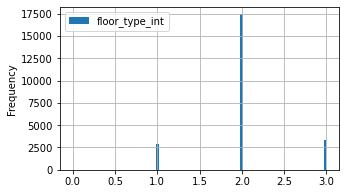

In [575]:
#1. Изучите следующие параметры объектов:

#- общая площадь;
#data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,500))
#data['total_area'].describe()

#- жилая площадь;
#data.plot(y = 'living_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,500))
#data['living_area'].describe()

#- площадь кухни;
#data.plot(y = 'kitchen_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,500))
#data['kitchen_area'].describe()

#- цена объекта;
#data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0,15000000), figsize = (5,3))
#data['last_price'].describe()

#- количество комнат;
#data.plot(y = 'rooms', kind = 'hist', bins = max(data.rooms), grid=True, figsize = (5,3))
#data['rooms'].describe()

#- высота потолков;
#data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (5,3))
#data['ceiling_height'].describe()
#Осталось еще одндваи выброса с 14 и 10 метровыми потолками и небольшой  площадью квартиры, удалим. 
#data.drop(data.index[data['ceiling_height'] >=  10], inplace = True)


#- этаж квартиры;
#data.plot(y = 'floor', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,60))
#data['floor'].describe()

#- тип этажа квартиры («первый», «последний», «другой»);
#data.plot(y = 'floor_type_int', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,3))
#data['floor_type_int'].describe()

#- общее количество этажей в доме;
#data.plot(y = 'floors_total', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,60))
#data['floors_total'].describe()

#- расстояние до центра города в метрах;
#data.plot(y = 'city_centers_nearest', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (0,65968.000000))
#data['city_centers_nearest'].describe()
#много зданий с 0, это те nan которые были  нами использованы

#- расстояние до ближайшего аэропорта;
#data.plot(y = 'airports_nearest', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (0,84869.000000))
#data['airports_nearest'].describe()
#в основном жилье сдается в отдалении от аэропорта, это логично. 

#- расстояние до ближайшего парка;
#data.plot(y = 'parks_nearest', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (0,84869.000000))
#data['parks_nearest'].describe()

#- день и месяц публикации объявления.
#день
#data.plot(y = 'day_of_week', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (0,6))
#data['day_of_week'].describe()
#По четвергам самый всплеск
#месяц
#data.plot(y = 'month', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (1,12))
#data['month'].describe()
#февраль самый активный



- В процессе обнаружил что не до конца  поправил данные по высоте потолков,  были удалены квартиры с потолком 10 и  14 метров т.к.  размер жилплощади у этих помещений был стандартный. 

- Расстояние до центра города в метрах - очень много нулевых значений, это те данные  где расстояние не было заполнено,  пока нет никаких идей  как можно  корректно заполнить такие параметры не удаляя их.

- Интересное наблюдение по этажности,  квартиры выше 33 этажа не продают хотя максимальный этаж шестидесятый. 

- В основном жилье  продается в удалении от аэропорта, логично.

- По четвергам наблюдается максимальная активность продаж жилья

- В феврале наблюдается максимальная активность продаж жилья

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'meter_price', 'day_of_week',
       'month', 'year', 'floor_type', 'distance_to_center'],
      dtype='object')

count    20468.000000
mean       180.748827
std        219.786428
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

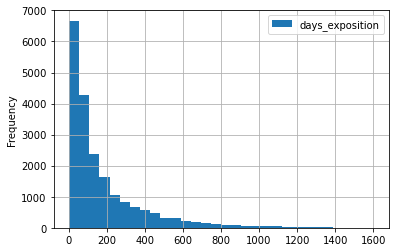

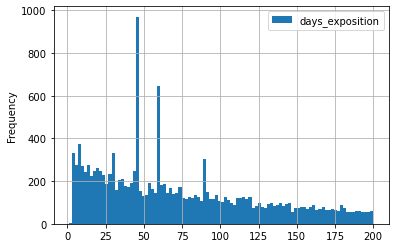

In [562]:
#2. Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.
#- Постройте гистограмму.
#- Посчитайте среднее и медиану.
#- В ячейке типа markdown опишите, сколько времени обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?

display(data.columns)

data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200))

#среднее значение, медиана и межквартильный размах
data[data['days_exposition']!=0]['days_exposition'].describe()
#data[data['days_exposition']!=0]['days_exposition'].value_counts()

Среднее значение - 180 дней медиана - 95 дней.
Сделав гистограмму со значениями от 0 до 200 с кол-вом корзин 100, обнаружили выбивающиеся значения и методом value_counts убедились в этом - у нас аномалии на 45, 60, 7, 30, 90 днях - это наиболее популярное количество дней до снятия объявления.

В правилах размещения объявлений в Яндекс Недвижимости, именно после этих сроков объявление считается неактуальным и снимается автоматически.

Возможно в дальнейшем обьявления о квартирах проданных  в эти дни из выборки уберем. 

0.30221041984911406

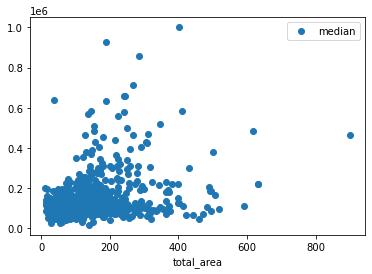

In [563]:
#3. Какие факторы больше всего влияют на общую (полную) стоимость объекта?
#- Изучите, зависит ли цена от:
#- общей площади;

pivot_table_total_area = data.pivot_table(index = 'total_area', values = 'meter_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')

pivot_table_total_area.sort_values('median', ascending = False)

data['total_area'].corr(data['meter_price'])

#Постройте графики, которые покажут зависимость цены от указанных выше параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.

От общей площади зависимость очень слабая - 0.3 Стоимость растет от размера площади. 

0.8742462457215306

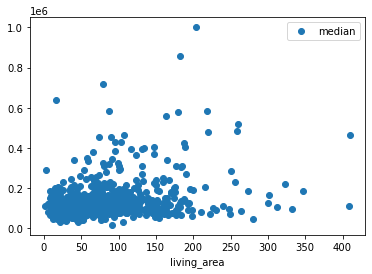

In [564]:
#- жилой площади;
pivot_table_total_area = data.pivot_table(index = 'living_area', values = 'meter_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')
pivot_table_total_area.sort_values('median', ascending = False)

data['total_area'].corr(data['living_area'])

In [ ]:
От жилой площади корреляция высокая, 0.87, чем больше жилая площадь тем выше цена.

0.5697430445965398

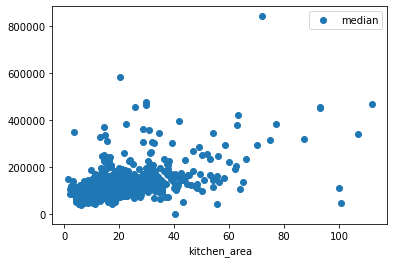

In [573]:
#- площади кухни;
pivot_table_total_area = data.pivot_table(index = 'kitchen_area', values = 'meter_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')
pivot_table_total_area.sort_values('median', ascending = False)

data['total_area'].corr(data['kitchen_area'])

От площади кухни кореляция слабая, 0.5

0.7587454506118994

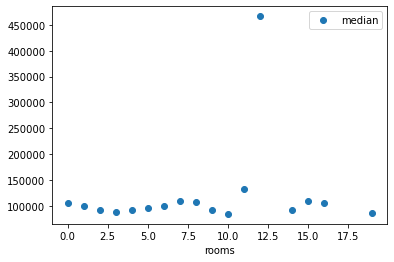

In [570]:
#- количества комнат;
pivot_table_total_area = data.pivot_table(index = 'rooms', values = 'meter_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')
pivot_table_total_area.sort_values('median', ascending = False)

data['total_area'].corr(data['rooms'])


#- этажа, на котором расположена квартира (первый, последний, другой);
#- даты размещения (день недели, месяц, год).

Наблюдается средняя корреляция от количества комнат

0.064476500453847

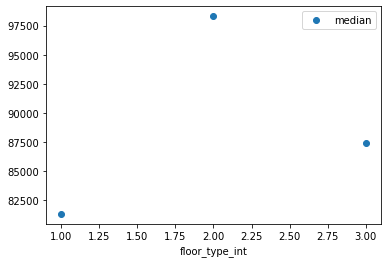

In [576]:
#- этажа, на котором расположена квартира (первый, последний, другой);
pivot_table_total_area = data.pivot_table(index = 'floor_type_int', values = 'meter_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')
pivot_table_total_area.sort_values('median', ascending = False)

data['total_area'].corr(data['floor_type_int'])


Очень слабая корреляция от типа этажа на котором расположена квартира 0.06

,mean,count,median
year,,,
2014,124302.355882,136,106901.900
2019,107123.780215,2879,103305.790
2018,97799.890724,8511,95703.120
2015,104719.098517,1173,93396.230
2017,97634.899244,8184,92569.055
2016,98295.372597,2765,91666.670


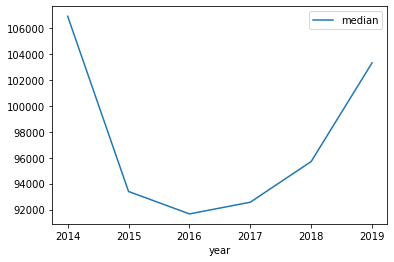

In [579]:
#- даты размещения (день недели, месяц, год).
pivot_table_year_exposition = data.pivot_table(index = 'year', values = 'meter_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_year_exposition.columns = ['mean', 'count', 'median']
pivot_table_year_exposition.plot(y = 'median')

pivot_table_year_exposition.sort_values('median', ascending = False)

В 2014 году мы можем наблюдать падение цен на жилье, в 2018  рост, жаль набор данных небольшой,  на текущий момент, в теории, рост должен был бы продолжаться. 

In [653]:
#Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 
#Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. 
#Эти данные можно найти по имени в столбце locality_name.

top_ten = data.locality_name.value_counts().head(10)
top_ten = top_ten.reset_index()
top_ten.columns = ('locality_name', 'cnt')

top_ten = data.query('locality_name in @top_ten.locality_name')

#выборку можно  получить и проще...  это первый пришедший в голову способ. 
top_ten = (top_ten.pivot_table(index = 'locality_name', values = 'meter_price', aggfunc = 'mean'))
top_ten = top_ten.reset_index()

top_ten.sort_values(by = 'meter_price', ascending = False)



,locality_name,meter_price
5,Санкт-Петербург,114849.008793
4,Пушкин,103125.819377
6,деревня Кудрово,92473.547559
8,посёлок Парголово,90175.913089
7,посёлок Мурино,86087.512017
9,посёлок Шушары,78677.364318
3,Колпино,75424.579112
2,Гатчина,68746.146515
0,Всеволожск,68654.473970
1,Выборг,58141.909325


В Питере из выборки наиболее высокая стоимость квадратного метра, если  жилье в Питере не по зубам, добро пожаловать в Выборг! 
В Выборге наиболее низвая стоимость из  топ 10.

In [694]:
#Ранее вы посчитали расстояние до центра в километрах. 
#Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name 
#и вычислите среднюю цену каждого километра. 
#Опишите, как стоимость объектов зависит от расстояния до центра города.


#Первым делом посчитаем сколько значений с 0 у нас в  питере:
#data.query('locality_name == "Санкт-Петербург" and distance_to_center == 0')['locality_name'].count()
#Тэк, 88,  а остальных? 
#data.query('locality_name == "Санкт-Петербург" and distance_to_center != 0')['locality_name'].count()
#15633  Выборка достаточная, можно отбросить нулевые значения. 

#Вспомнил про бритву Оккама и решил  написать все одной строчкой.  Не сложно ли такое читать? 
data.query('locality_name == "Санкт-Петербург" and distance_to_center != 0').pivot_table(index = 'distance_to_center', values = 'meter_price').sort_values(by = 'meter_price', ascending = False)


,meter_price
distance_to_center,
1.0,177005.407604
2.0,157849.007290
7.0,156176.879524
6.0,151012.193673
5.0,140509.789022
4.0,133282.874738
27.0,132115.710000
8.0,125671.442864
3.0,121387.453743


Ожидаемо, в самом центре самое дорогое жилье, как и на максимальном удалении самое недорогое, 
но есть и данные выбивающиеся из статистики, например на 7 месте стоимость жилья  на 27 километре. 
Причина - нестандартно дорогое или нестандартно большое жилье которое соответственно дорого стоит. 
Плюс среднее значение больше подвержено выбросам чем медиана. 

### Общий вывод

Был изучен  файл данных **real_estate_data.csv**, выводы следующие:

- Набор данных с очень большим количеством пропусков, это видно по тепловой карте. 
- Формат хранения данных изначально в большей части  строковой
- Даты без указания времени

Скорее всего эти ошибки связаны с веб формой, к примеру,расстояние до центра можно вычислить если знать адрес.

- Данные были приведены в правильный формат,  в датах убрали время, столбцы стали  int  и  float, выбросы проанализированы и скорректированы каждый наиболее подходящим образом. 
- Для меня самой сложной частью проекта было найти и устранить неявные дубликаты,  сперва было найдено  что ошибки только в  наименованиях типов поселений,  после чего  был присвоен топ 1  тип поселения ко всем похожим. 
- Также мы добавили  допольнительные столбцы для удобства анализа. 
- Провели подробный исследовательский анализ в рещультате которого  были обнаружены  дополнительные выбросы  высоты потолков, 
- Обнаружили в 2014 году падение цен на жилье а в 2018 рост
- Выяснили как быстро продавались квартиры и обнаружили аномалии на 45, 60, 7, 30, 90 днях (даты снятия объявлений), нашли среднее значение в 180 дней и медиану - 95 дней.
- Выяснили что наибольшая зависимость стоимости квартиры от жилой площади
- Узнали что в  питере в 3х километровой зоне самое дорогое жилье, а для желающих сэкономить всегда есть вариант переехать в Выборг. 


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод